# This notebook is for prelimary EDA

In [1]:
#Check if colab is connect to gpu
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [2]:
# Check if colab is using high-RAm runtime
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 37.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
pip install pydub

In [4]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import librosa
import librosa.display
import pydub
import joblib



### Load in the Data

In [5]:
train, test, val = tfds.load('speech_commands', split=['train', 'test', 'validation'])


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/speech_commands/0.0.2.incompleteNZ6OUJ/speech_commands-train.tfrecord


  0%|          | 0/85511 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/speech_commands/0.0.2.incompleteNZ6OUJ/speech_commands-validation.tfrecord


  0%|          | 0/10102 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/speech_commands/0.0.2.incompleteNZ6OUJ/speech_commands-test.tfrecord


  0%|          | 0/4890 [00:00<?, ? examples/s]

Dataset speech_commands downloaded and prepared to /root/tensorflow_datasets/speech_commands/0.0.2. Subsequent calls will reuse this data.


In [6]:
type(train)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

### Print out info about the classes and label names

In [7]:
builder = tfds.builder('speech_commands')
info = builder.info
commands = info.features['label'].names
print(info.features['label'].num_classes)
print(f'Commands {commands}')

12
Commands ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']


### Examples of audio clips

In [8]:
ds, info = tfds.load('speech_commands', split = 'train', with_info = 'True')

In [9]:
tfds.as_dataframe(ds.take(4), info)

audio  label
0  [-15, -18, -12, -21, -22, -13, -21, -22, -13, ...      4
1  [75, 29, -85, 5, 68, -13, -61, 18, 60, -48, -3...      5
2  [0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, ...      7
3  [1, 15, 13, 11, 2, -19, -19, -11, -5, 14, 27, ...      5

# Create DataFrames

In [10]:
def create_dataframe(data):
  ''' Create a dataframe with audio as wavelength in the form numpy.array, float 32
  Returns pandas dataframe

  Key Arguments
  data: tensorflow.python.data.ops.dataset_ops.PrefetchDataset
  '''
  data_df = pd.DataFrame(data)
  data_df['label'] =  [x.numpy() for x in data_df['label']]
  data_df['audio'] = [tf.constant(x) for x in data_df['audio']]
  data_df['audio'] = [ x.numpy() for x in data_df['audio']]
  data_df['audio'] = [ x.astype(np.float32) for x in data_df['audio']]
  data_df['label_command'] =  [ commands[label] for label in data_df['label']]

  return data_df

In [11]:
train_df = create_dataframe(train)
test_df = create_dataframe(test)
val_df = create_dataframe(val)

In [12]:
train_df[train_df['label'] == 8]

,audio,label,label_command
36,"[-17.0, -67.0, -72.0, -79.0, -62.0, -30.0, -73...",8,up
112,"[-27.0, -31.0, -34.0, -37.0, -34.0, -44.0, -47...",8,up
128,"[-9.0, -8.0, -12.0, -16.0, -19.0, -20.0, -20.0...",8,up
151,"[2.0, 2.0, 4.0, 1.0, 5.0, 5.0, 0.0, 2.0, 3.0, ...",8,up
177,"[3.0, 2.0, 0.0, -1.0, -4.0, -5.0, -6.0, -8.0, ...",8,up
...,...,...,...
85413,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8,up
85420,"[2.0, 3.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...",8,up
85447,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8,up
85459,"[-9.0, -12.0, -14.0, -15.0, -19.0, -20.0, -21....",8,up


### Print out information about the data

In [13]:
print(f'Shape of training data {train_df.shape}')
print(f'Shape of testing data {test_df.shape}')
print(f'Shape of valing data {val_df.shape}') 

Shape of training data (85511, 3)
Shape of testing data (4890, 3)
Shape of valing data (10102, 3)


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85511 entries, 0 to 85510
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   audio          85511 non-null  object
 1   label          85511 non-null  int64 
 2   label_command  85511 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


### Save data

In [15]:
joblib.dump(train_df, './drive/MyDrive/audio_commands/data/train_df.sav')
joblib.dump(test_df, './drive/MyDrive/audio_commands/data/test_df.sav')
joblib.dump(val_df, './drive/MyDrive/audio_commands/data/val_df.sav')


['./drive/MyDrive/audio_commands/data/val_df.sav']

### Create Initital visualizations

In [16]:
x = train_df['audio'][0].astype(np.float32)
label_x = train_df['label'][0]

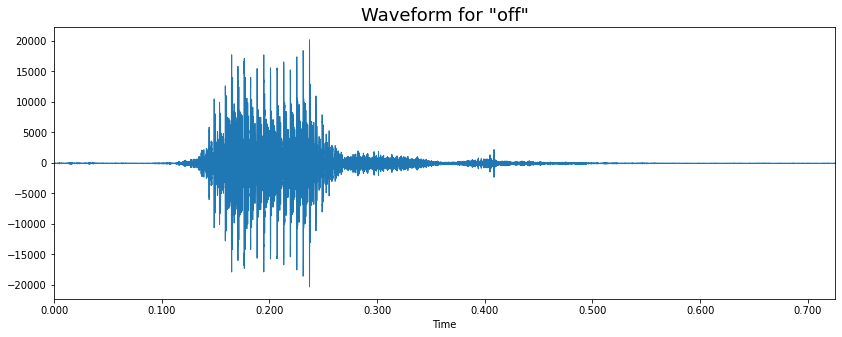

In [17]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x)
title = 'Waveform for "' + str(commands[label_x]+ '"') 
plt.title(title, fontsize = 18);

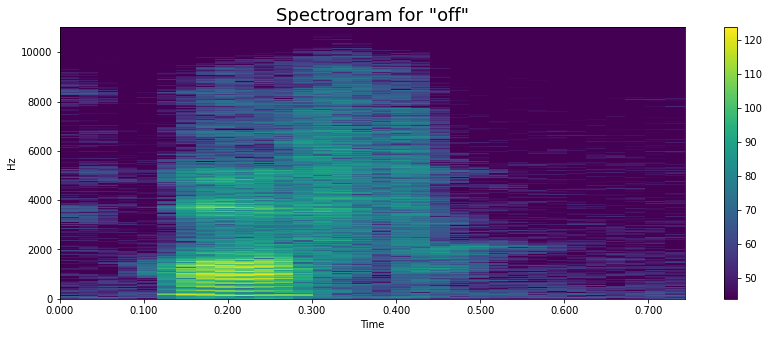

In [18]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr = 22050, x_axis = 'time', y_axis = 'hz', cmap = 'viridis')
plt.colorbar()
title = 'Spectrogram for "' + str(commands[label_x]+ '"') 
plt.title(title, fontsize = 18);

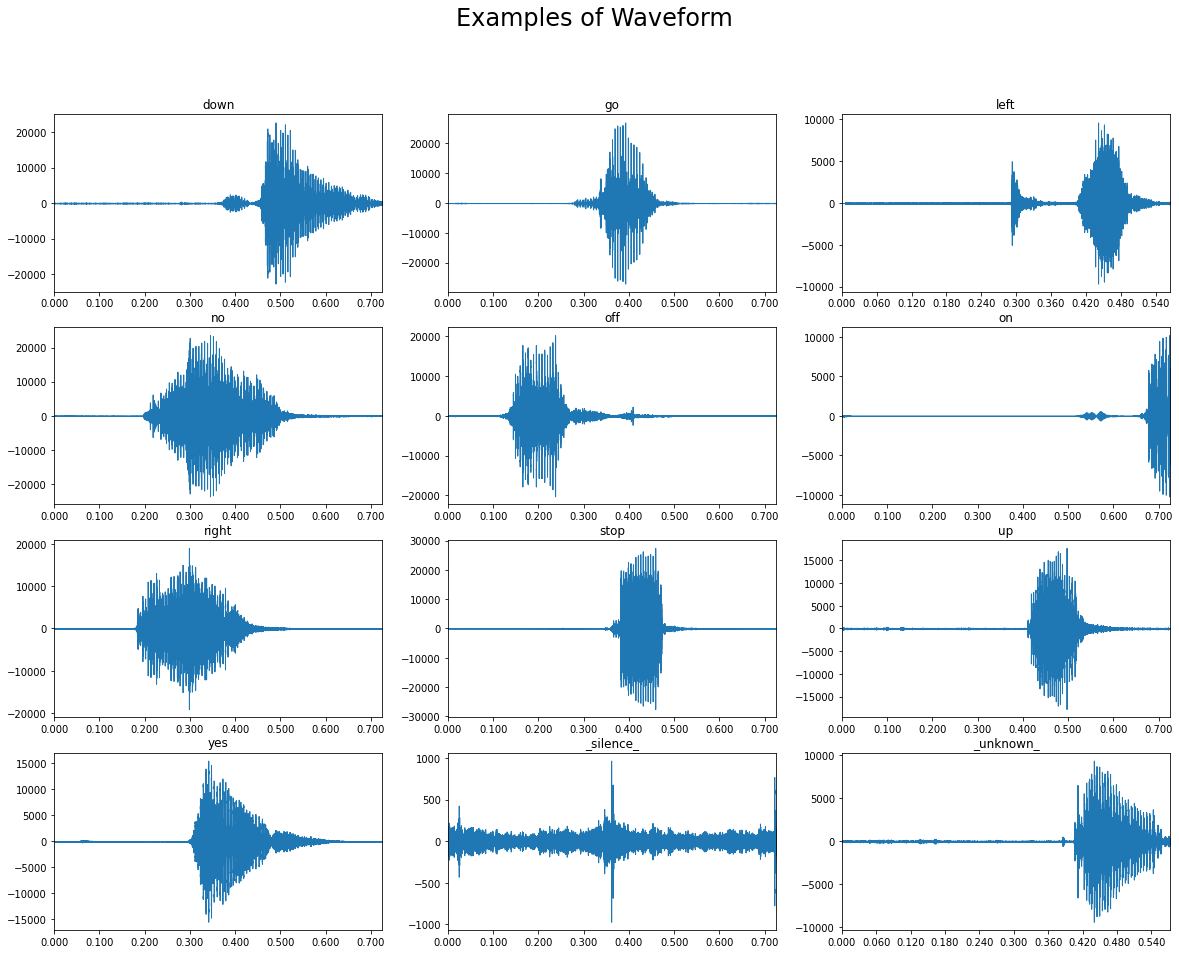

In [26]:
# a plot of some a few audio waveforms

rows = 4
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))


for i, example in  enumerate([75, 25, 5, 37,0,1,8,2,36,31,16,6]):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  waveform = train_df['audio'][example]
  librosa.display.waveplot(waveform, ax = ax)
  ax.set(xlabel = '')
  ax.set_title(train_df['label_command'][example])

plt.suptitle('Examples of Waveform', fontsize = 24, va = 'top', x = 0.5, y = .98)
fig1 = plt.gcf()
plt.show()
fig1.savefig('./drive/MyDrive/audio_commands/visuals/waveform.png');